In [1]:
!git clone https://github.com/HaiNLH/CrossCBR.git

Cloning into 'CrossCBR'...
remote: Enumerating objects: 906, done.
remote: Counting objects: 100% (254/254), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 906 (delta 167), reused 171 (delta 111), pack-reused 652
Receiving objects: 100% (906/906), 169.80 MiB | 25.68 MiB/s, done.
Resolving deltas: 100% (429/429), done.


In [2]:
%cd CrossCBR

/kaggle/working/CrossCBR


In [3]:
import argparse
import numpy as np
import pandas as pd
import os
import scipy.sparse as sp
from sklearn.preprocessing import normalize
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
def get_graph(path, x, y):
    with open(os.path.join(path), 'r') as f:
        b_i_pairs = list(map(lambda s: tuple(int(i) for i in s[:-1].split('\t')), f.readlines()))

    indice = np.array(b_i_pairs, dtype=np.int32)
    values = np.ones(len(b_i_pairs), dtype=np.float32)
    b_i_graph = sp.coo_matrix(
        (values, (indice[:, 0], indice[:, 1])), shape=(x, y)).tocsr()
    return b_i_graph


def save_sp_mat(csr_mat, name):
    sp.save_npz(name, csr_mat)


def load_sp_mat(name):
    return sp.load_npz(name)

def filter(threshold, mat):
    mask = mat >= threshold
    mat = mat * mask
    return mat

def gen_ii_asym(ix_mat, threshold=0):
    '''
    mat: ui or bi
    '''
    ii_co = ix_mat @ ix_mat.T
    i_count = ix_mat.sum(axis=1)
    i_count += (i_count == 0) # mask all zero with 1
    # norm_ii = normalize(ii_asym, norm='l1', axis=1)
    # return norm_ii
    # return ii_asym
    mask = ii_co > threshold
    ii_co = ii_co.multiply(mask)
    ii_asym = ii_co / i_count
    # normalize by row -> asym matrix
    return ii_co

def get_cmd():
    parser = argparse.ArgumentParser()
    # experimental settings
    parser.add_argument("-d", "--dataset", default="NetEase", type=str, help="dataset to train")
    args = parser.parse_args()
    return args

def get_stat(path):
    with open(path, 'r') as f:
        a, b, c = f.readline().split('\t')
    return int(a), int(b), int(c)


if __name__ == '__main__':
    
#     paras = get_cmd().__dict__
    dataset_name = 'Steam'

    users, bundles, items = get_stat(f'datasets/{dataset_name}/{dataset_name}_data_size.txt')
    dir = f'datasets/{dataset_name}'
    path = [dir + '/user_bundle_train.txt',
            dir + '/user_item.txt',
            dir + '/bundle_item.txt']
    
    raw_graph = [get_graph(path[0], users, bundles),
                 get_graph(path[1], users, items),
                 get_graph(path[2], bundles, items)]

    ub, ui, bi = raw_graph

    pbar = tqdm(enumerate([ui.T, bi.T]), total = 2, desc="gene", ncols=100)
    asym_mat = []
    for i, mat in pbar:
        asym_mat.append(gen_ii_asym(mat))

    pbar = tqdm(enumerate(["/iui_asym.npz", "/ibi_asym.npz"]), total = 2, desc="save", ncols=100)
    for i, data in pbar:
        save_sp_mat(asym_mat[i], dir + data)

save: 100%|███████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.83it/s]


In [6]:
# from gene_ii_asym import load_sp_mat

iui = load_sp_mat('datasets/Steam/iui_asym.npz')
print(iui.getnnz())
ibi = load_sp_mat('datasets/Steam/ibi_asym.npz')
print(ibi.getnnz())


ii_b_max = int(ibi.max())
print(ii_b_max)
ii_u_max = int(iui.max())
print(ii_u_max)


# bundle
print("statistic")
print("ii bundle")
lb1 = []
val1 = []
for i in range(1, 10):
    lb1.append(f'{i}')
    count = ibi.multiply(ibi == i).getnnz()
    val1.append(count)
    p = count / ibi.getnnz() * 100
    print("==", i, ":", p, "%")

count = ibi.multiply(ibi >= 10).getnnz()
val1.append(count)
lb1.append(f">={10}")
p = count / ibi.getnnz() * 100
print(">=", 10, ":", p, "%")


# user
print("ii user")
lb2 = []
val2 = []
for i in range(1, 10):
    lb2.append(f'{i}')
    count = iui.multiply(iui == i).getnnz()
    val2.append(count)
    p = count / iui.getnnz() * 100
    print("==", i, ":", p, "%")

count = iui.multiply(ibi >= 10).getnnz()
val2.append(count)
lb2.append(f">={10}")
p = count / ibi.getnnz() * 100
print(">=", 10, ":", p, "%")

1624184
54241
7
23849
statistic
ii bundle
== 1 : 90.36890912778158 %
== 2 : 9.127781567448977 %
== 3 : 0.4148153610737265 %
== 4 : 0.07190132925277926 %
== 5 : 0.011061742961966041 %
== 6 : 0.0036872476539886803 %
== 7 : 0.0018436238269943402 %
== 8 : 0.0 %
== 9 : 0.0 %
>= 10 : 0.0 %
ii user
== 1 : 15.83496697418519 %
== 2 : 8.707634110420987 %
== 3 : 5.102008146860208 %
== 4 : 3.8719135270388083 %
== 5 : 3.3862542667579536 %
== 6 : 3.1907099195657636 %
== 7 : 3.056858089970102 %
== 8 : 2.9523748540805723 %
== 9 : 2.674758524896194 %
>= 10 : 0.0 %


In [7]:
val1, val2

([49017, 4951, 225, 39, 6, 2, 1, 0, 0, 0],
 [257189, 141428, 82866, 62887, 54999, 51823, 49649, 47952, 43443, 0])

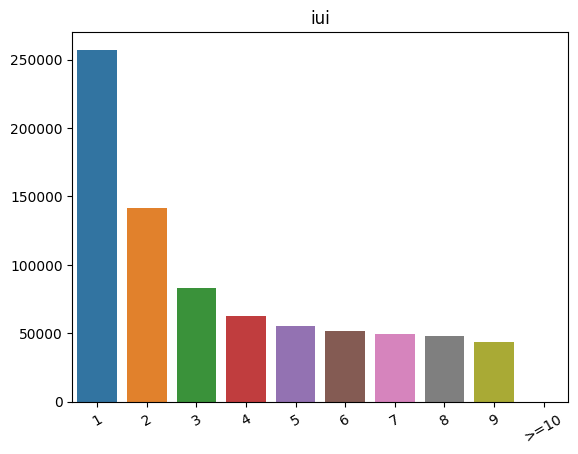

In [8]:
plt.title('iui')
temp1 = sns.barplot(x=lb2, y=val2)
temp1.set_xticklabels(temp1.get_xticklabels(), rotation=30)
plt.show()

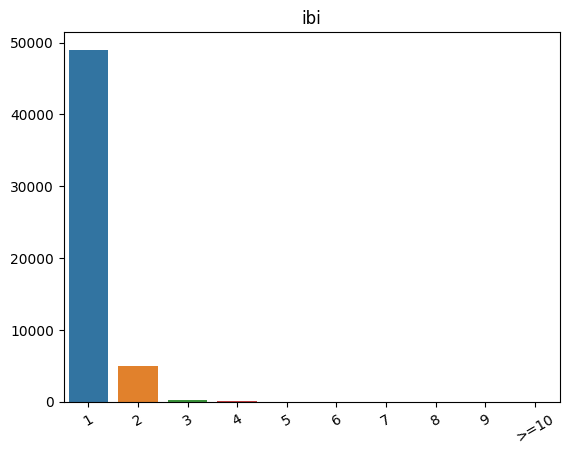

In [9]:
plt.title('ibi')
temp2 = sns.barplot(x=lb1, y=val1)
temp2.set_xticklabels(temp2.get_xticklabels(), rotation=30)
plt.show()

In [10]:
ub, ui, bi

(<29634x615 sparse matrix of type '<class 'numpy.float32'>'
 	with 52539 stored elements in Compressed Sparse Row format>,
 <29634x2819 sparse matrix of type '<class 'numpy.float32'>'
 	with 902967 stored elements in Compressed Sparse Row format>,
 <615x2819 sparse matrix of type '<class 'numpy.float32'>'
 	with 3541 stored elements in Compressed Sparse Row format>)

In [11]:
iu = ui.T
ib = bi.T
iu_count = iu.sum(axis=1)
ib_count = ib.sum(axis=1)

In [12]:
ib_count.max(), iu_count.max()

(7.0, 23849.0)

In [13]:
ib_count, iu_count

(matrix([[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]], dtype=float32),
 matrix([[   25.],
         [  164.],
         [    0.],
         ...,
         [    0.],
         [    0.],
         [11601.]], dtype=float32))

In [15]:
temp1 = []
labels = []
g = 0
th = 20
for i in range(0, th):
    v = (ib_count == i).sum()
    temp1.append(v)
    labels.append(f'{i}')
    print(v)
    g+=v
    
v = (ib_count >= th).sum()
temp1.append(v)
labels.append(f'>{th-1}')
print(v)
g+=v

0
2245
471
71
23
6
2
1
0
0
0
0
0
0
0
0
0
0
0
0
0


In [17]:
temp2 = []
labels2 = []
g2 = 0
th2 = 20
for i in range(0, th2):
    v2 = (iu_count == i).sum()
    temp2.append(v2)
    labels2.append(f'{i}')
    print(v2)
    g+=v2
    
v2 = (iu_count >= th).sum()
temp2.append(v)
labels2.append(f'>{th-1}')
print(v)
g2+=v

1409
57
54
28
31
25
15
11
20
13
10
6
10
12
13
14
11
7
12
11
0


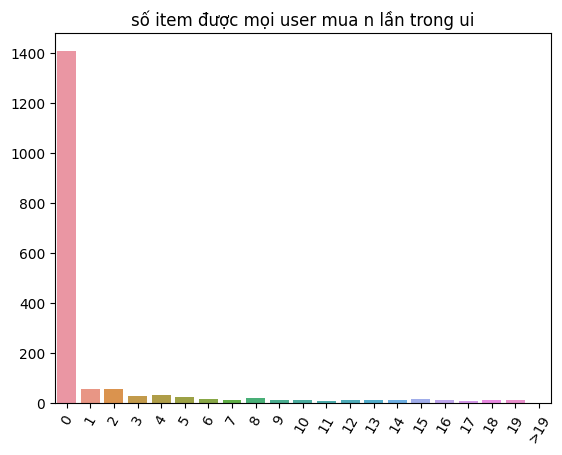

In [18]:
#  VD item 1 được mọi người mua 6 lần (mỗi người max 1 lần do cấu tạo dataset) -> cột 6: +1 
plt.title('số item được mọi user mua n lần trong ui')
iuc = sns.barplot(x=labels2, y=temp2)
iuc.set_xticklabels(iuc.get_xticklabels(), rotation=60)
plt.show()

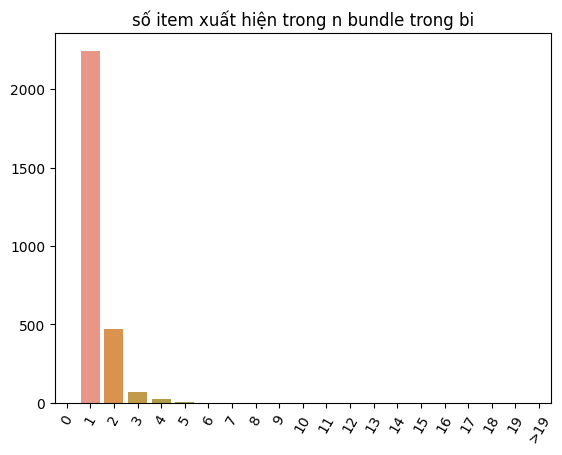

In [19]:
# VD item 4 xuất hiện trong bundle 2, 4, 6 -> cột 3: + 1
plt.title('số item xuất hiện trong n bundle trong bi')
ibc = sns.barplot(x=labels, y=temp1)
ibc.set_xticklabels(ibc.get_xticklabels(), rotation=60)
plt.show()

### New task 31/10


C:\WORK\DS-KT\Amazon_data\datasets


In [20]:
import pandas as pd
bi = pd.read_csv('/kaggle/input/amazon-data/Steam/bundle_item.txt', delimiter = "\t",header = None, names = ['bundle_id','item_id'])

In [21]:
bi

,bundle_id,item_id
0,0,1304
1,0,291
2,0,739
3,0,742
4,0,1705
...,...,...
3536,613,115
3537,613,643
3538,614,1743
3539,614,259


In [22]:
import itertools

# Assuming bundle_df is your DataFrame with columns "bundle_id" and "item_id"
# You can adapt this code to fit your specific DataFrame structure

unique_bundles = bi['bundle_id'].unique()
bundle_pairs = list(itertools.combinations(unique_bundles, 2))



# Now overlap_dict contains the overlaps for all possible bundle pairs

In [23]:
bi.describe

<bound method NDFrame.describe of       bundle_id  item_id
0             0     1304
1             0      291
2             0      739
3             0      742
4             0     1705
...         ...      ...
3536        613      115
3537        613      643
3538        614     1743
3539        614      259
3540        614       87

[3541 rows x 2 columns]>

In [24]:
from tqdm import tqdm
overlap_dict = {}
count = 0
data=[]
for bundle1, bundle2 in tqdm(bundle_pairs):
    items_in_bundle1 = set(bi[bi['bundle_id'] == bundle1]['item_id'])
#     print(f"Bundle_id:{bundle1} ")
#     print(f"{items_in_bundle1}\n")
    items_in_bundle2 = set(bi[bi['bundle_id'] == bundle2]['item_id'])
#     print(f"Bundle_id: {bundle2}" )
#     print(f"{items_in_bundle2}\n")
    overlap = items_in_bundle1.intersection(items_in_bundle2)
    num_items_bundle1 = len(items_in_bundle1)
    num_items_bundle2 = len(items_in_bundle2)
    num_overlap_items = len(overlap)
    if num_items_bundle1 == 0 or num_items_bundle2 == 0:
        jaccard_ratio = 0.0
    else:
        jaccard_ratio = num_overlap_items / (num_items_bundle1 + num_items_bundle2 - num_overlap_items)
    if overlap:
        # Store the overlap in a dictionary with a unique key for each pair
#         print(overlap)
        data.append({'bundle_id1': bundle1, 'bundle_id2': bundle2, 'num_bundles1': num_items_bundle1, 'num_bundles2': num_items_bundle2, 'overlap': num_overlap_items, 'jaccad': jaccard_ratio})
#         key = (bundle1, bundle2)
#         overlap_dict[key] = overlap
    count +=1
    # Store the overlap in a dictionary with a unique key for each pair
#     if count>1000:
#         break

100%|██████████| 187578/187578 [02:30<00:00, 1248.25it/s]


In [17]:
# df = pd.DataFrame(data)
datapath= 'food'
import pandas as pd
df = pd.read_csv(f'C:\WORK\DS-KT\Amazon_data\datasets\{datapath}.csv')

In [18]:
df

,bundle_id1,bundle_id2,num_bundles1,bum_bundles2,overlap,jaccad
0,0,1,7,4,4,0.571429
1,0,2,7,2,2,0.285714
2,4,20,8,10,1,0.058824
3,4,21,8,4,1,0.090909
4,4,76,8,6,1,0.076923
...,...,...,...,...,...,...
3753,1767,1768,2,2,1,0.333333
3754,1770,1771,2,4,2,0.500000
3755,1773,1774,3,2,2,0.666667
3756,1776,1777,8,9,8,0.888889


In [19]:
df['jaccad'].describe()

count    3758.000000
mean        0.217561
std         0.176356
min         0.052632
25%         0.100000
50%         0.142857
75%         0.250000
max         1.000000
Name: jaccad, dtype: float64

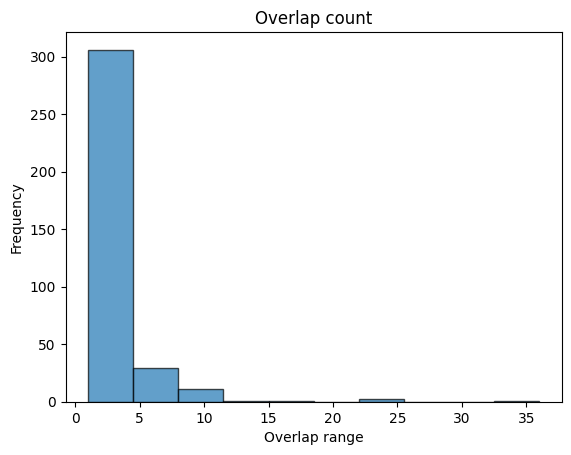

In [27]:
plt.hist(df['overlap'], bins=10, edgecolor='k', alpha=0.7)
plt.xlabel('Overlap range')
plt.ylabel('Frequency')
plt.title('Overlap count')
plt.show()

In [28]:
df.to_csv('Steam.csv', index=False)